In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
# from snmfem.experiments import load_samples, print_results, load_data, run_experiment
from snmfem.measures import KL, trace_xtLx
from snmfem.updates import multiplicative_step_a, multiplicative_step_p, multiplicative_step_aq
from snmfem.conf import log_shift, dicotomy_tol
from snmfem.laplacian import sigmaL, create_laplacian_matrix
from snmfem.estimators.smooth_nmf import diff_surrogate


In [3]:
def create_toy_problem(l = 25, k = 3, p = 100, c = 10, n_poisson=200, force_simplex=True):

    A = np.random.rand(k,p)
    if force_simplex:
        A = A/np.sum(A, axis=0, keepdims=True)
    
    G = np.random.rand(l,c)
    P = np.random.rand(c,k)
    GP = G @ P

    X = GP @ A

    Xdot = 1/n_poisson * np.random.poisson(n_poisson * X)

    return G, P, A, X, Xdot

In [14]:

shape_2d = [10, 15]
k = 5
n_poisson = 200
G, P, A, Xtrue, X = create_toy_problem(p = shape_2d[0]*shape_2d[1], k=k, n_poisson=n_poisson)

P1 = np.random.rand(*P.shape)
A1 = np.random.rand(*A.shape)
# A1 = A1/np.sum(A1, axis=0, keepdims=True)
P2 = P1.copy()
A2 = A1.copy()

P3 = P1.copy()
A3 = A1.copy()
P0 = P1.copy()
A0 = A1.copy()

L = create_laplacian_matrix(*shape_2d)

lambda_L = 10

def loss(P, A):
    DA = G @ P @ A
    v1 = KL(X, DA) 
    v2 = trace_xtLx(L, A.T)
    return v1 + lambda_L/2 * v2

maxit = 1000
force_simplex = False
loss0 = [loss(P0, A0)]

loss1 = [loss(P1, A1)]
loss2 = [loss(P2, A2)]
diff_loss2 = []
loss3 = [loss(P3, A3)]
diff_loss3 = []

# gamma2 = sigmaL
gamma2 = 1e-3
gamma2 = 0.005

gamma3 = sigmaL
gamma3_vec = [gamma3]
d3 = []

for i in range(maxit):
    A0 = multiplicative_step_a(X, G, P0, A0, force_simplex=force_simplex, lambda_L=lambda_L, L=L)
    P0 = multiplicative_step_p(X, G, P0, A0)
    loss0.append(loss(P0, A0))
    
    A1 = multiplicative_step_aq(X, G, P1, A1, force_simplex=force_simplex, lambda_L=lambda_L, L=L)
    P1 = multiplicative_step_p(X, G, P1, A1)
    loss1.append(loss(P1, A1))

    
    A2 = multiplicative_step_aq(X, G, P2, A2, force_simplex=force_simplex, lambda_L=lambda_L, L=L, sigmaL=gamma2)
    diff_loss2.append(loss2[-1]-loss(P2, A2))

    P2 = multiplicative_step_p(X, G, P2, A2)
    loss2.append(loss(P2, A2))
    A3_old = A3.copy()
    A3 = multiplicative_step_aq(X, G, P3, A3, force_simplex=force_simplex, lambda_L=lambda_L, L=L, sigmaL=gamma3)
    d3.append(diff_surrogate(A3_old, A3, L=L, sigmaL=gamma3))
    diff_loss3.append(d3)
    if d3[-1]>0:
        gamma3 = gamma3 / 1.2
    else:
        gamma3 = gamma3 * 1.5
    gamma3_vec.append(gamma3)
        
    P3 = multiplicative_step_p(X, G, P3, A3)
    loss3.append(loss(P3, A3))
    

In [15]:
gamma3

0.006209411764457121

In [16]:
for i in range(10*maxit):
    A2 = multiplicative_step_aq(X, G, P2, A2, force_simplex=force_simplex, lambda_L=lambda_L, L=L, sigmaL=gamma2)
    P2 = multiplicative_step_p(X, G, P2, A2)

l_infty = loss(P2, A2)

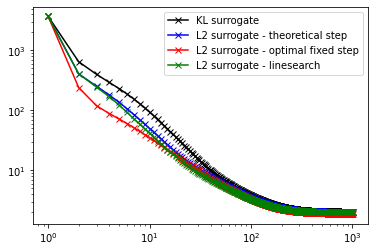

In [17]:
iterations = np.arange(maxit+1)+1
plt.plot(iterations, np.array(loss0)-l_infty, "kx-", label="KL surrogate")
plt.plot(iterations, np.array(loss1)-l_infty, "bx-", label="L2 surrogate - theoretical step")
plt.plot(iterations, np.array(loss2)-l_infty, "rx-", label="L2 surrogate - optimal fixed step")
plt.plot(iterations, np.array(loss3)-l_infty, "gx-", label="L2 surrogate - linesearch")
plt.yscale("log")
plt.xscale("log")
plt.legend()


Text(0.5, 1.0, 'Evolution of the step size')

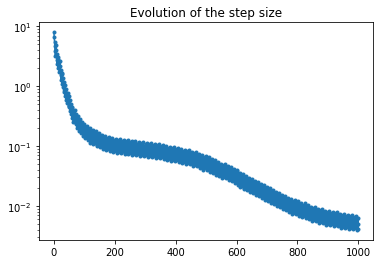

In [18]:
plt.plot(gamma3_vec, ".-")
plt.yscale("log")
plt.title("Evolution of the step size")


In [ ]:
gamma3

In [ ]:
# def f(x, a, b, c):
#     v = x + b
#     return v - np.sqrt( v**2 + 4*a*c) +2*a 
# p = 1
# x = np.arange(-2,2, 0.1)
# a = np.random.rand(p)
# a = 0.5
# b = np.random.rand(p)
# c = np.random.rand(p)
# plt.plot(x, f(x,a,b,c))
# plt.plot(x, np.zeros_like(x))